In [1]:
import pandas as pd 
import numpy as np
from functools import partial
from glob import glob

from pymongo import MongoClient

from utils.misc import read_mongo, batch
from utils.geolocation import CachedGeolocator, region_fixer, locality_fixer, countryName_fixer, address_to_location
from utils.dk021 import DK021
from utils.etl import transform_dataset


%matplotlib inline

### Transform Chunked

In [3]:
batch_size = 50_000

# connect to tenders db
cursor = MongoClient()['prozorro']['etenders'].find(no_cursor_timeout=True)


try:
    for idx, b in enumerate(batch(cursor, batch_size)):

        transform_dataset(
            df=pd.DataFrame(b).rename(columns={'_id':'id'})
        ).to_parquet(f'./data/prepared/chunk_{idx}.parquet.gzip', compression='gzip') 

        print(f'chunk {idx}')
# except Exception as e:
#     print(e)
finally:
    cursor.close()

### Restore & enreach

In [2]:
files = sorted(glob('./data/prepared/chunk_*.parquet.gzip'))

full_df = pd.read_parquet(files[0])
for f in files[1:]:
    full_df = pd.concat([full_df, pd.read_parquet(f)])


In [4]:
classifier = DK021.load('./data/dk021.csv')
# geo and classifier
fixers = {
    'locality': locality_fixer,
    'region': region_fixer,
    'countryName': countryName_fixer
}
geolocator = CachedGeolocator(cache_dir='./data/geo_cache', bad_cache_dir='./data/geo_cache_bad', verbose=False)
get_location = partial(address_to_location, geolocator=geolocator, fixers=fixers)
classifier = DK021.load('./data/dk021.csv')


full_df = (
    full_df
    .query('~items_code.isna()')
    .assign(
        items_classification_l1 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=1).code),
        items_classification_l2 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=2).code),
        items_classification_l3 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=3).code)
    )
    .assign(
        procuringEntity_geo = lambda d: d.procuringEntity_address.apply(lambda address:get_location(address)),
        bids_tenderers_geo = lambda d: d.tenderers_address.apply(lambda address:get_location(address)),
    )
)

geolocator.close()

In [2]:
from utils.misc import mem_usg

# classifier = DK021.load('./data/dk021.csv')
full_df = pd.read_parquet('./data/enreached/full.parquet.gzip')

mem_usg(full_df)/(1024*1024)

5143.497758865356

In [3]:
mem_usg(full_df.astype({
    'owner': 'category', 
    'procurementMethod': 'category', 
    'status': 'category', 
    'procurementMethodType': 'category',
    'procuringEntity_kind': 'category', 
    'procuringEntity_identifier_scheme': 'category', 
    'value_currency': 'category', 
    'bids_status': 'category',
    'bids_tenderers_identifier_scheme': 'category', 
    'bids_value_currency': 'category', 
    'awards_value_currency': 'category', 
    'items_code': 'category',
    'items_classification_l1': 'category', 
    'items_classification_l2': 'category',
    'items_classification_l3': 'category'
}).drop(columns=['procuringEntity_address','tenderers_address']))/(1024*1024)

3840.0748462677

In [26]:
# calc distance
from geopy import distance
full_df['geo_distance']=full_df.apply(
    lambda x: distance.distance(x.procuringEntity_geo, x.bids_tenderers_geo).km 
        if all([x.procuringEntity_geo is not None, x.bids_tenderers_geo is not None]) 
        else pd.NA, 
    axis=1
)


In [31]:
full_df.geo_distance.isna().value_counts()

False    2154765
True      218044
Name: geo_distance, dtype: int64

### Example Economy

In [3]:
# TO SHOW
# tender bids lots awards
# items
# dk021, geo



In [7]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9'][['id', 'lots_id',  'bids_id', 'items_code', 'items_classification_l1', 'items_classification_l2', 'items_classification_l3', 'numberOfBids', 'num_lots',  'awards_status', 'status', 'value_amount', 'bids_value_amount', 'awards_value_amount']]

,id,lots_id,bids_id,items_code,items_classification_l1,items_classification_l2,items_classification_l3,numberOfBids,num_lots,awards_status,status,value_amount,bids_value_amount,awards_value_amount
76067,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1215fd8627904632b2771d21998006e5,33141113-4,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,1060036.0,1052085.85,NaN
76068,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,15935b3d80944ce2b1fa5bdc63bcc5d3,33141113-4,33000000-0,33100000-1,33140000-3,2,2,active,complete,1060036.0,1019377.02,1019377.02
76069,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,1215fd8627904632b2771d21998006e5,33140000-3,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,2270252.0,2267523.67,NaN
76070,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,15935b3d80944ce2b1fa5bdc63bcc5d3,33140000-3,33000000-0,33100000-1,33140000-3,2,2,active,complete,2270252.0,2266848.50,2266848.50


In [8]:
classifier = DK021.load('./data/dk021.csv')

In [15]:
full_df.items_classification_l1.value_counts()

45000000-7    291205
15000000-8    231823
09000000-3    230018
33000000-0    227106
30000000-9    160485
39000000-2    137493
44000000-0    132987
50000000-5     98026
34000000-7     76170
03000000-1     75330
31000000-6     73379
71000000-8     71979
42000000-6     53879
18000000-9     47384
24000000-4     43459
32000000-3     41046
79000000-4     38334
90000000-7     36162
38000000-5     33127
22000000-0     28799
72000000-5     26326
14000000-1     25643
35000000-4     24035
37000000-8     20981
55000000-0     20744
19000000-6     14997
77000000-0     13421
48000000-8     12616
66000000-0     11911
60000000-8      8915
80000000-4      8301
43000000-3      6939
98000000-3      6762
85000000-9      6452
16000000-5      6173
51000000-9      5891
75000000-6      4414
92000000-1      4256
63000000-9      3422
73000000-2      3273
64000000-6      3238
99999999-9      1708
41000000-9      1555
70000000-1      1181
76000000-3      1137
65000000-3       327
Name: items_classification_l1, dty

In [14]:
classifier.get_level_category('33141113-4',level=5).description

'Бинти'

In [4]:
full_df.dtypes

id                                                     string
date                                      datetime64[ns, UTC]
dateModified                              datetime64[ns, UTC]
tenderID                                               string
owner                                                category
procurementMethod                                    category
submissionMethod                                     category
numberOfBids                                             int8
status                                               category
procurementMethodType                                category
mainProcurementCategory                              category
procuringEntity_name                                   string
procuringEntity_kind                                 category
procuringEntity_address                                object
num_lots                                                 int8
procuringEntity_identifier_id                          string
procurin

In [43]:
full_df.date.max()

Timestamp('2021-10-31 21:01:23.914932+0000', tz='UTC')

In [28]:
(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .assign(
        economy = lambda d: d.value_amount - d.awards_value_amount,
        est_economy = lambda d: d.value_amount - d.value_amount*0.65
    )
)[['economy', 'est_economy']].astype(np.int64).sum()



economy        132597677057
est_economy    546155392707
dtype: int64

In [32]:
(546155583773 - 132597946873)/1_000_000

413557.6369

In [34]:
cnt_eco=(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount)/d.value_amount
    )
    .groupby(by=['numberOfBids'])
    .agg({
        'id': 'count',
        'economy': 'mean',
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .rename(columns={'id':'cnt'})
    .query('cnt>1000')
    .sort_values(by='numberOfBids')
    .assign(
        count_log = lambda d: np.log2(d.cnt)*15
    )
)
cnt_eco

,numberOfBids,cnt,economy,value_amount,awards_value_amount,count_log
0,1,272064,4.818293,5.545546e+10,5.364767e+10,270.803798
1,2,300337,10.025346,8.612403e+11,8.116753e+11,272.943340
2,3,120906,18.662282,3.106225e+11,2.792178e+11,253.252895
3,4,59413,23.539578,1.292211e+11,1.112743e+11,237.877365
4,5,28961,28.048722,7.365568e+10,6.141915e+10,222.327357
5,6,14807,30.416978,2.792069e+10,2.291922e+10,207.809876
6,7,7794,33.004112,2.568979e+10,2.031637e+10,193.922223
7,8,4498,33.923021,2.605870e+10,2.308378e+10,182.026019
8,9,2469,35.615195,8.148888e+09,6.866796e+09,169.045667
9,10,1461,36.696603,8.343116e+09,7.052200e+09,157.691107


In [36]:
avg_eco = 100*(cnt_eco.value_amount.sum() - cnt_eco.awards_value_amount.sum())/cnt_eco.value_amount.sum()
avg_eco

8.443876365284083

In [37]:
avg_eco_at_5 = cnt_eco[cnt_eco.numberOfBids==5].economy.iloc[0]
avg_eco_at_5

28.048721521108288

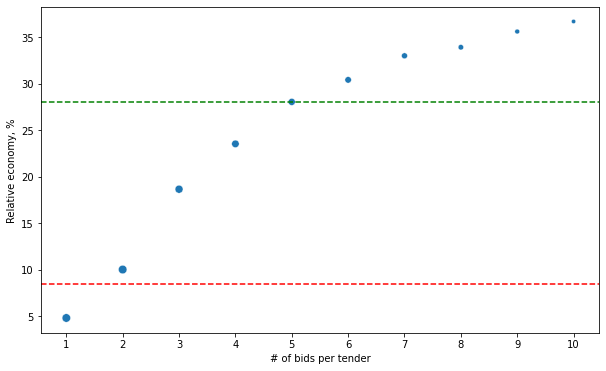

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(avg_eco, ls='--', color='red')
ax.axhline(avg_eco_at_5, ls='--', color='green')
ax = sns.scatterplot(ax=ax, data=cnt_eco, x="numberOfBids", palette="deep", y="economy", size='count_log', legend=False)
ax.set_xlabel('# of bids per tender')
ax.set_ylabel('Relative economy, %')
ax.set_xticks(cnt_eco.numberOfBids.to_list());